In [0]:
## simple demo of Gibbs sampler for a Gaussian distribution (with a conjugate prior)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from IPython import display
%matplotlib inline

In [0]:
def gauss_multiply(a, A, b, B):
    
    D = A.shape[0]
    
    AB = A + B
    L = np.linalg.cholesky(AB)              # cholesky factorization of the covariance
    
    S = A @ np.linalg.solve(AB, B) # covariance matrix
    m = B @ np.linalg.solve(AB, a) + A @ np.linalg.solve(AB, b) # mean
    alpha = np.linalg.solve(L, (a-b))            # precomputation
    z = np.exp(-0.5*np.sum(alpha**2, axis=0))/((2*np.pi)**(0.5*D)*np.prod(np.diag(L)))
    return m, S, z

In [0]:
## initialization
mu = 10*np.ones((2,1))
Sigma = 10*np.eye(2)

## hyper-parameters for mu (Gaussian prior)
mu0 = 4.0*np.random.normal(size=(2,1))
Sigma0 = np.eye(2)

## hyper-parameters for Sigma (inverse Wishart prior)
Psi = np.eye(2)
kappa = 1

In [0]:
# sample x
N = 100 # number of samples

# generate data
muTrue = np.array([3,1])
SigmaTrue = np.zeros((2,2))
SigmaTrue[0][0] = 2
SigmaTrue[1][1] = 2
SigmaTrue[0][1] = -1
SigmaTrue[1][0] = SigmaTrue[0][1]

data = np.random.multivariate_normal(muTrue, SigmaTrue, N).T

Text(0.5,1,'True distribution')

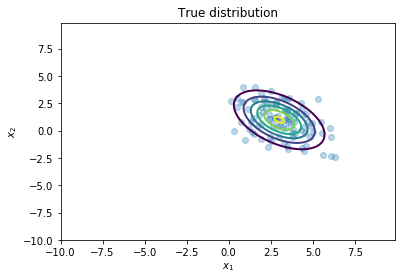

In [0]:
# generate a mesh-grid for evaluating the pdf
x, y = np.mgrid[-3*np.sqrt(SigmaTrue[0][0])+muTrue[0]:3*np.sqrt(SigmaTrue[0][0])+muTrue[0]:.1, 
                -3*np.sqrt(SigmaTrue[1][1])+muTrue[1]:3*np.sqrt(SigmaTrue[1][1])+muTrue[1]:.1]

x, y = np.mgrid[-10:10:.1, -10:10:.1]
# stack x-y coordinates
pos = np.dstack((x, y))


# generate Gaussian object
gaussian = stats.multivariate_normal(muTrue[0:2], SigmaTrue[0:2,0:2])

# evaluate the Gaussian pdf at the x-y coordinates
z = gaussian.pdf(pos)

plt.figure()
plt.contour(x, y, z, linewidths=2)
plt.scatter(data[0,:], data[1,:], alpha=0.3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("True distribution")


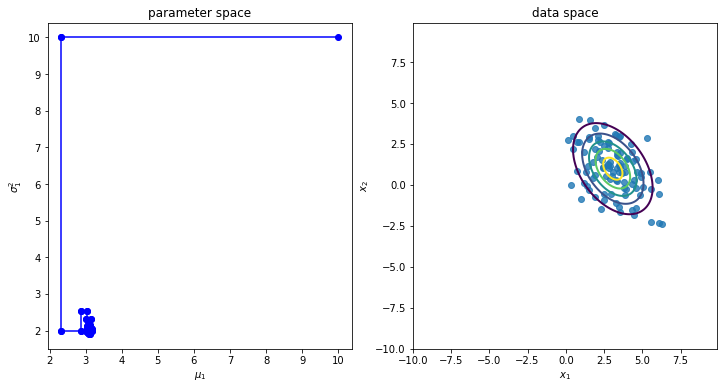

In [0]:
number_gibbs_iterations = 50

m_list = [mu[0]]
s_list = [Sigma[0][0]]

plt.figure(figsize=(12,6))


for i in range(number_gibbs_iterations):
    
    # posterior hyper-parameters for mu
    mu0, Sigma0, _ = gauss_multiply(np.mean(data,axis=1).reshape(-1,1), Sigma/N, mu0, Sigma0)
    
    # sample a mean from the hyper-parameter posterior
    mu = np.random.multivariate_normal(mean=mu0.ravel(), cov=Sigma0).reshape(-1,1)
    m_list.append(mu[0])
    
    ### plotting
    plt.subplot(121)
    plt.title("parameter space")
    plt.xlabel("$\mu_1$")
    plt.ylabel("$\sigma^2_1$")
    plt.plot([m_list[-2], m_list[-1]], [s_list[-1], s_list[-1]], 'b', marker = 'o')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    # posterior hyper-parameters for Sigma
    A = np.zeros((2,2))
    for n in range(N):
        A += (data[:,n].reshape(-1,1)-mu) @ (data[:,n].reshape(-1,1)-mu).T

    Psi += A   # update scale parameter
    kappa += N # update degrees of freedom parameter

    # sample Sigma
    Sigma = stats.invwishart.rvs(df=kappa, scale=Psi)
    
    ## plotting
    s_list.append(Sigma[0][0])
    plt.plot([m_list[-1], m_list[-1]], [s_list[-2], s_list[-1]], 'b', marker = 'o')
    
    plt.subplot(122)
    plt.cla()

    plt.title("data space")

    # generate Gaussian object
    gaussian = stats.multivariate_normal(mu.ravel(), Sigma)

    # evaluate the Gaussian pdf at the x-y coordinates
    z = gaussian.pdf(pos)

    plt.contour(x, y, z, linewidths=2)
    plt.scatter(data[0,:], data[1,:], alpha=0.8)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    display.display(plt.gcf())
    display.clear_output(wait=True)
    

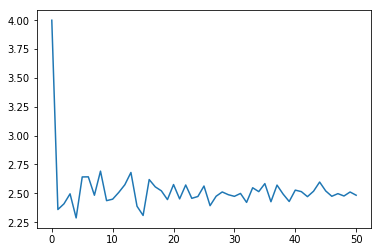

In [0]:
plt.plot(s_list)